# Quantinuum Specification Data

This notebook contains an overview of loading and analyzing experiments used to measure the Quantinuum Specification metrics, found in the *Quantinuum System Model H1 Product Data Sheet*.

The data is collected from five experiments to measure the five metrics. Further details of each experiment are given below.
1. Single-qubit randomized benchmarking (`'SQ_RB'`): Method to measure single-qubit gate errors. Similar to methods in Ref. [1].
2. Two-qubit randomized benchmarking (`'TQ_RB'`): Method to measure two-qubit gate errors.  Similar to methods in Ref. [1].
3. Memory randomized benchmarking (`'Memory_RB'`): Method to measure average depth-1 (random qubit pairing) memory errors
4. Measurement decay (`'Bright_depump'`): Method to measure measurement crosstalk errors (errors due to measurement of neighboring qubits). Method is described in Ref. [2].
5. State preperation and measruement (`'SPAM'`): Method to measure state preparation and measurement errors.

**References** <br>
[1] E. Magesan et al. Phys. Rev. A 85, 042311 (2012) <br>
[2] J. P. Gaebler et al. Phys. Rev. A 104, 062440 (2021) <br>

## Loading data

Each data file is saved as a dictionary in a json file with five keys:
- `survival`: nested dictionary of correct output counts for different qubits, lengths, and repetitions
- `leakage_postselect`: (only newer RB tests) rate that leakage gadget identifies a leaked state at end of circuit
- `expected_output`: nested dictionary of expected output string for different qubits, lengths, and repetitions
- `sequence_info`: dictionary with keys=length, values=number of repetitions
- `qasm`: dictionary with keys=`'length, rep index'` and value=qasm run on machine
- `raw data`: dictionary with same keys as above with list outputs strings from each shot of the experiment
- `shots`: number of shots for each circuit

Available datasets:
- `'H1-1/2022_06_09'`
- `'H1-1/2023_01_20'`
- `'H1-2/2022_06_09'`
- `'H2-1/2023_03_10'`

In [3]:
machine = 'H2-1'
date = '2023_03_10'

## Load all data

In [4]:
from qtm_spec.combined_analysis import combined_report
import pathlib

data_dir = pathlib.Path.cwd().parent.joinpath('data')

df = combined_report(data_dir, machine, date, ['SQ_RB', 'TQ_RB', 'Memory_RB', 'Measurement_crosstalk', 'SPAM'])
df

,Magnitude,Uncertainty
Single-qubit gate error,2.498E-05,2.862E-06
Single-qubit spontaneous emission,7.394E-06,3.551E-06
Two-qubit gate error,1.834E-03,4.558E-05
Two-qubit spontaneous emission,7.884E-04,4.008E-05
Memory error,2.161E-04,3.063E-05
Measurement crosstalk error,4.435E-06,7.337E-07
SPAM error,1.563E-03,1.396E-04


In [5]:
df.to_excel(pathlib.Path.cwd().parent.joinpath('summary table.xlsx'))

## Loading RB data

The following experiments are analyzed with randomized benchmarking (RB) methods (`rb_type`):

- `'SQ_RB'`: Single-qubit RB with random single-qubit Clifford gates done in parallel with two qubits in each active gate zone
- `'TQ_RB'`: Two-qubit RB with random two-qubit Clifford gates done in parallel two qubits in each active gate zone
- `'Memory_RB'`: Single-qubit RB done in parallel across all available qubits in the trap and interleaved with random transport. The random transport is induced by using conditional two-qubit gates between random pairs of qubits and setting the condition to always fail. An additional delay is included after each failed conditional gate to simulate the time required for ion cooling.

There are two analysis options (`data_type`):
- `'survival'`: Survival probability that gives the overall error rate
- `'leakage_postselect'`: Leakage postselect rate with leakage gadget that identifies leakage errors due to spontaneous emission

In [6]:
import pathlib
import json

rb_type = 'TQ_RB'  # options: 'SQ_RB', 'TQ_RB', 'Memory_RB'
data_type = 'survival'  # options: 'survival', 'leakage_postselect'

file_name = f'{machine}/{date}/{rb_type}.json'
data_dir = pathlib.Path.cwd().parent.joinpath('data')

with open(data_dir.joinpath(file_name), 'r') as f:
    data = json.load(f)

Each data file is analyzed with `rb_analysis()` function to output the estimated fidelity of the gates.

In [7]:
from qtm_spec.rb_analysis_functions import rb_analysis

fid_info, boot_info = rb_analysis(data_dir, machine, date, rb_type, data_type)

### Report Table

The table contains RB intercept and avg fidelity estimations with uncertainty from semi-parametric bootstrap resampling and basic bootstrap one-sigma confidence intervals. 

IMPORTANT NOTE: The RB intercept in the table below comes from the fit to the RB decay curve. For `'SQ_RB'` it is close to the SPAM metric discussed below but for `'TQ_RB'` it will be much larger since it contains error from one two-qubit Clifford gate.

In [8]:
from qtm_spec.rb_reporting_functions import report

report(fid_info, boot_info, machine, data_type)

,Avg. infidelity,Avg. infidelity uncertainty,RB Intercept,RB Intercept uncertainty
DG01,1.953E-03,9.773E-05,9.403E-03,4.013E-03
DG02,1.751E-03,8.759E-05,9.093E-03,3.925E-03
DG03,1.846E-03,1.039E-04,5.175E-03,4.106E-03
DG04,1.791E-03,8.400E-05,5.617E-03,3.663E-03
Mean,1.835E-03,4.682E-05,7.322E-03,1.965E-03


### Plotting results

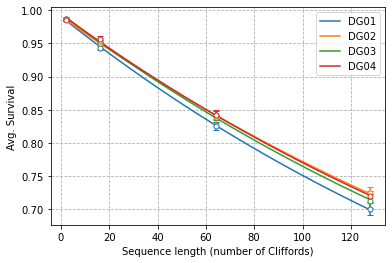

In [9]:
from qtm_spec.rb_reporting_functions import errorbar_plot

errorbar_plot(fid_info, data, machine, data_type, savename='H1-1_TQ_RB')

## Loading bright decay datasets

Measurement crosstalk errors are extracted by bright state depumping experiments, which measure the rate that bright state population is depumped by measurement on neighboring qubits. The experiment is repeated for qubits on each side of the gate zones.

In [10]:
import pathlib
import json

experiment = 'Measurement_crosstalk'
file_name = f'{machine}/{date}/{experiment}.json'

data_dir = pathlib.Path.cwd().parent.joinpath('data')

with open(data_dir.joinpath(file_name), 'r') as f:
    data = json.load(f)

In [11]:
from qtm_spec.decay_analysis_functions import decay_analysis

fid_info, boot_info = decay_analysis(data_dir, machine, date, experiment)

### Report table

The table contains Decay intercept and avg infidelity estimates for measurement crosstalk errors. Uncertainty is calculated with a parametric bootstrap resampling and basic bootstrap one-sigma confidence interval.

IMPORTANT NOTE: The Decay intercept in the table below comes from the fit to the bright state depumping decay curve. It is close to the SPAM metric discussed below.

In [12]:
from qtm_spec.decay_reporting_functions import report

report(fid_info, boot_info, machine, experiment)

,Avg. infidelity,Avg. infidelity uncertainty,Decay intercept,Decay intercept uncertainty
DG01-left,1.795E-06,1.319E-06,1.427E-03,8.289E-04
DG01-right,1.669E-06,1.789E-06,1.670E-03,1.164E-03
DG02-left,2.430E-05,3.183E-06,1.212E-24,7.288E-04
DG02-right,5.419E-06,2.392E-06,3.282E-03,1.453E-03
DG03-left,1.197E-06,1.435E-06,2.286E-03,1.032E-03
DG03-right,8.321E-07,1.125E-06,1.337E-03,8.072E-04
DG04-left,1.581E-07,5.367E-07,1.405E-03,5.828E-04
DG04-right,4.790E-07,1.016E-06,2.047E-03,8.562E-04
Mean,4.481E-06,6.305E-07,1.682E-03,3.418E-04


### Plot decay

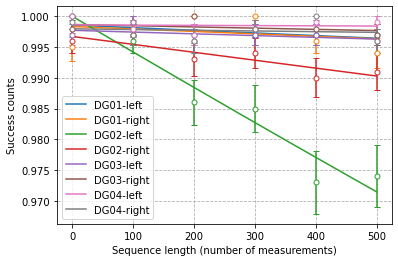

In [13]:
from qtm_spec.decay_reporting_functions import errorbar_plot

errorbar_plot(fid_info, data_dir, machine, date, experiment)

## Loading SPAM data

The SPAM dataset is a single file with all bright and all dark detections for two ions per active gate zone.

In [14]:
import pathlib
import json

experiment = 'SPAM'
file_name = f'{machine}/{date}/{experiment}.json'

data_dir = pathlib.Path.cwd().parent.joinpath('data')

with open(data_dir.joinpath(file_name), 'r') as f:
    data = json.load(f)

### Report table

The table contains the 0 and 1 state success frequency and the Avg SPAM across both states. Uncertainty is calculated by binomial standard deviation.

In [15]:
from qtm_spec.spam_reporting_functions import report

report(data_dir, machine, date, experiment)

,Avg. SPAM error,Avg. SPAM error uncertainty,0 SPAM error,1 SPAM error
DG01-left,1.500E-03,3.869E-04,8.000E-04,2.200E-03
DG01-right,1.600E-03,3.996E-04,1.000E-03,2.200E-03
DG02-left,1.900E-03,4.354E-04,1.000E-03,2.800E-03
DG02-right,2.000E-03,4.467E-04,1.200E-03,2.800E-03
DG03-left,1.900E-03,4.354E-04,1.200E-03,2.600E-03
DG03-right,1.600E-03,3.995E-04,4.000E-04,2.800E-03
DG04-left,8.000E-04,2.827E-04,6.000E-04,1.000E-03
DG04-right,1.200E-03,3.462E-04,8.000E-04,1.600E-03
Mean,1.562E-03,1.396E-04,8.750E-04,2.250E-03


<div align="center"> &copy; 2023 by Quantinuum. All Rights Reserved. </div>